In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf


from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Functions

In [2]:
def calc_adj_r_sq(model, X, y):
    n, p = X.shape
    r_sq = model.score(X, y)
    r_sq_adj = 1 - (1 - r_sq) * (n - 1) / (n - p - 1)
    
    return r_sq_adj


def sklearn_vif(covariates):
    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}
    only_numeric = (covariates.dtypes == 'int') | (covariates.dtypes == 'float')
    covariates
    
    # form input data for each exogenous variable
    for covariate in covariates:
        covs = [i for i in covariates if i != covariate]
        X, y = covariates[covs], covariates[covariate]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1 / (1 - r_squared)
        vif_dict[covariate] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[covariate] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif


def cooks_distances_stat_models(model, y, return_cooks=False, *args, **kwargs):
    treshold = 3 * y.mean()
    influence = model.get_influence()
    cooks = influence.cooks_distance
    g = sns.barplot(x=list(range(len(cooks[0]))), y=cooks[0], *args, **kwargs)
    g.axes.xaxis.set_ticklabels([])
    plt.xlabel('Observation')
    plt.ylabel("Cook's distance")
    plt.axhline(y=treshold, color='r', linestyle='-')
    plt.show()
    
    if return_cooks:
        return cooks
    
    
def resid_distribution(model, scale=True, **kwargs):
    if scale:
        res = (model.resid - model.resid.mean()) / model.resid.std()
    else:
        res = model.resid
    plt.scatter(model.fittedvalues, res, **kwargs)
    plt.xlabel('Fittedvalue')
    plt.ylabel('Model residue')
    plt.axhline(y=0, color='black', linestyle='-')
    plt.axhline(y=-2, color='r', linestyle='-')
    plt.axhline(y=2, color='r', linestyle='-')
    
    
def qqPlot(data, **kwargs):
    _ = sm.qqplot(data, marker='o', markerfacecolor='w', markeredgecolor="k", line="s", **kwargs)
    

def select_sign_covs(model, X_train_dropped, y_train, alpha=0.05):
    while True:
        if max(model.pvalues) > alpha:
            drop_variable = model.pvalues[model.pvalues == max(model.pvalues)]
            print(f"Dropping {drop_variable.index[0]} and running regression again because pvalue is: {drop_variable[0]}")
            X_train_dropped = X_train_dropped.drop(columns=[drop_variable.index[0]])
            model = sm.OLS(y_train, X_train_dropped).fit()
        else:
            print("All p values less than 0.05")
            return X_train_dropped
            break
            

In [3]:
warnings.filterwarnings('ignore')
sns.set(font_scale=1.5, rc={'figure.figsize':(10, 7)}, style='whitegrid')
np.random.seed(1)

## Loading data

In [59]:
ins_data = pd.read_csv('data/insurance.csv')
ins_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
ins_data.shape

(1338, 7)

## Cheking data types

In [6]:
ins_data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

## Some EDA

In [7]:
ins_data[ins_data.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [60]:
# Drop duplicates
ins_data = ins_data.drop_duplicates()

In [9]:
ins_data.shape

(1337, 7)

In [10]:
ins_data.count()

age         1337
sex         1337
bmi         1337
children    1337
smoker      1337
region      1337
charges     1337
dtype: int64

There are no missing values by the first check, but it can be masked with 9999 or smth else..

In [11]:
ins_data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

We can see that here we have 4 groups based on $smoker$ and $sex$ variables. This groups are not pretty balanced, so we have to take it into account.

In [12]:
ins_pivot = ins_data.pivot_table(index=['smoker', 'sex'], aggfunc='count')
ins_pivot

age  bmi  charges  children  region
smoker sex                                        
no     female  547  547      547       547     547
       male    516  516      516       516     516
yes    female  115  115      115       115     115
       male    159  159      159       159     159

We can see that if you smokes you mb have a higher charges.

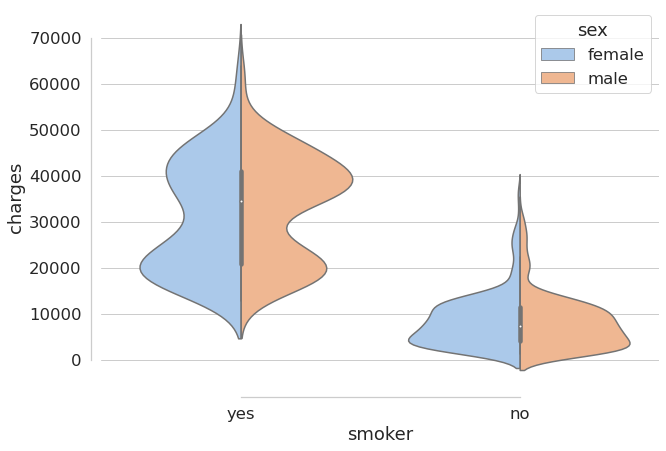

In [13]:
sns.violinplot(hue="sex", y='charges', x='smoker', 
               split=True, 
               palette='pastel', data=ins_data)
sns.despine(offset=10, trim=True)

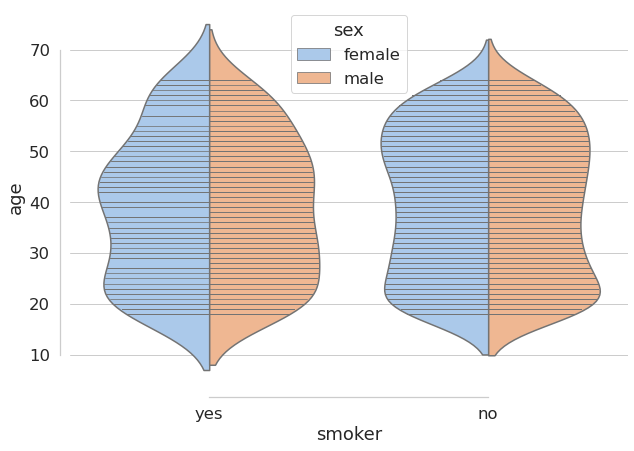

In [14]:
sns.violinplot(hue="sex", y='age', x='smoker', 
               split=True, inner="stick", 
               palette='pastel', data=ins_data)
sns.despine(offset=10, trim=True)

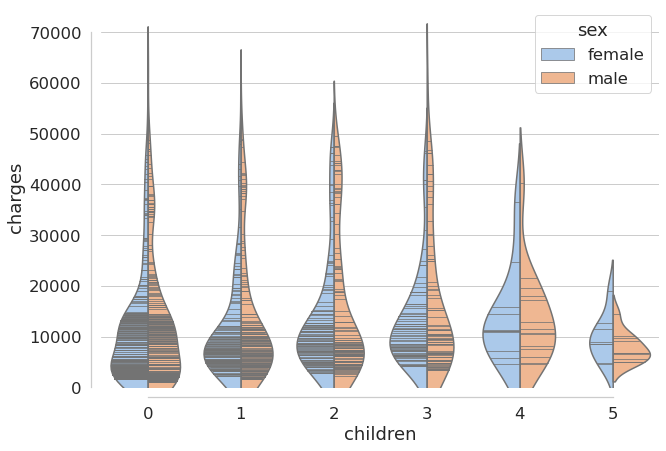

In [15]:
sns.violinplot(hue="sex", y='charges', x='children', 
               split=True, inner="stick", 
               palette='pastel', data=ins_data)
plt.ylim(0, 75000)
sns.despine(offset=10, trim=True)

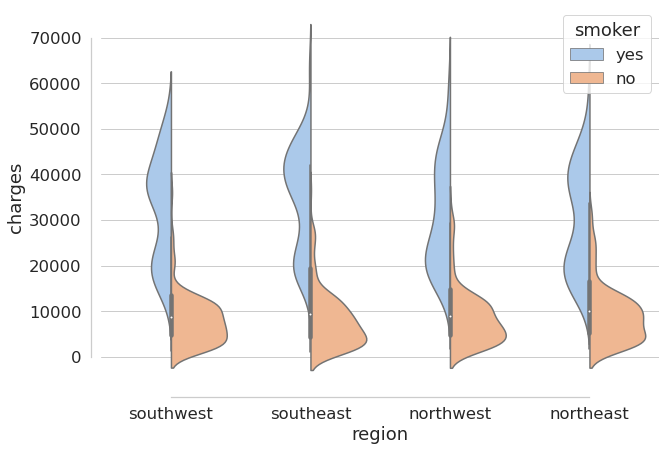

In [16]:
sns.violinplot(hue="smoker", y='charges', x='region', 
               split=True, 
               palette='pastel', data=ins_data)
sns.despine(offset=10, trim=True)

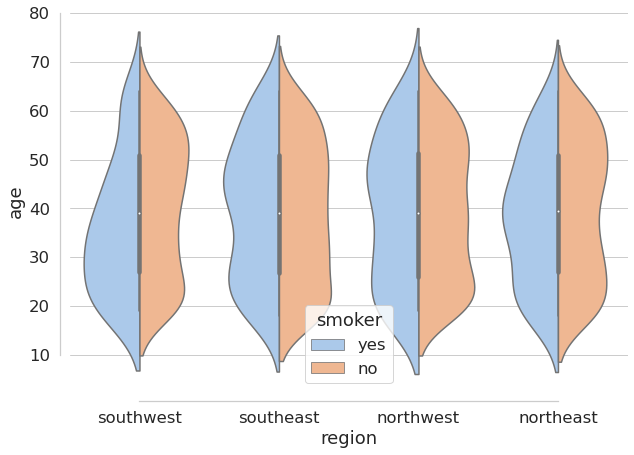

In [17]:
sns.violinplot(hue="smoker", y='age', x='region', 
               split=True, 
               palette='pastel', data=ins_data)
sns.despine(offset=10, trim=True)

In generall we can say that *region* is a balanced variable and may not affect our depending variable *charges*. It can be a good idea do not use *region* in our model.

<AxesSubplot:xlabel='region', ylabel='children'>

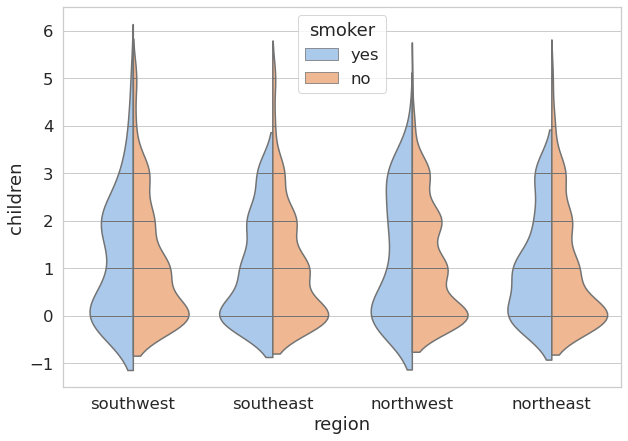

In [18]:
sns.violinplot(y='children', x='region', hue='smoker', 
               split=True, inner="stick", 
               palette='pastel', data=ins_data)

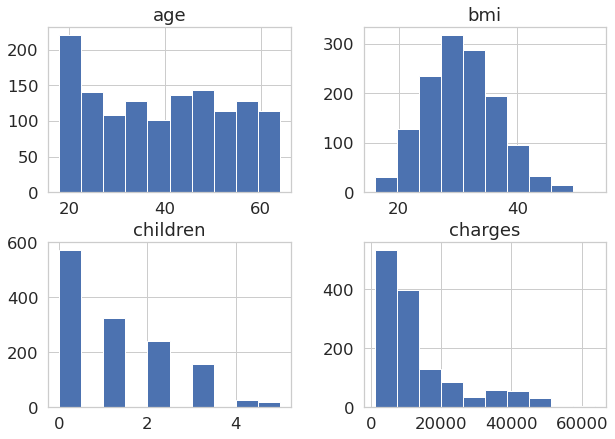

In [19]:
ins_data.hist()
plt.show()

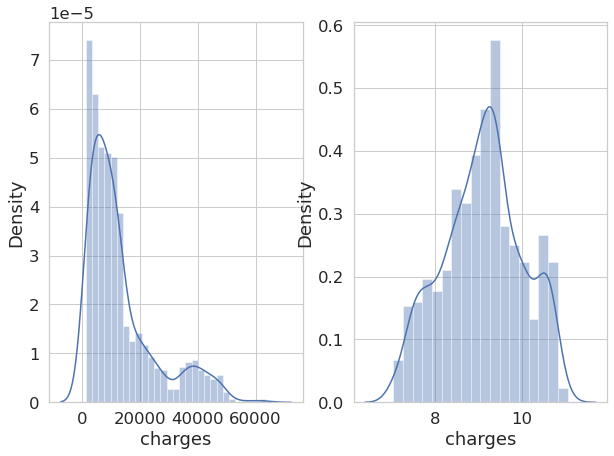

In [20]:
fig, axs = plt.subplots(1, 2)
sns.distplot(ins_data['charges'], ax=axs[0])
sns.distplot(np.log(ins_data['charges']), ax=axs[1])
plt.show()

So if we want to useboxplotnnear regression dependent variable must have normal distribution. So I will transform our dependent variable $charges$ with log transformation.

In [21]:
stats.normaltest(np.log(ins_data['charges']))

NormaltestResult(statistic=52.147628145443655, pvalue=4.745548606594116e-12)

As we can see even log transformation can't make our situation much more better, but we still can try to apply linear regression. 

<AxesSubplot:>

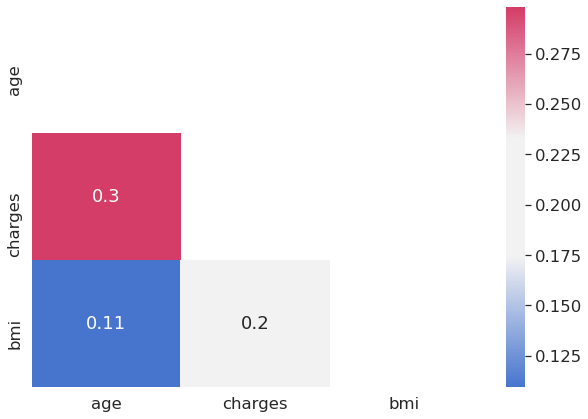

In [22]:
corr = ins_data.loc[:, ['age', 'charges', 'bmi']].corr()
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True
mask = np.ones((3, 3)) - mask + np.eye(3)
sns.heatmap(corr, cmap=sns.diverging_palette(256, 0, sep=80, as_cmap=True), annot=True, mask=mask)

Here we can see some correlations between our quantitative variables, especially in groups based on $smoker$ variable.

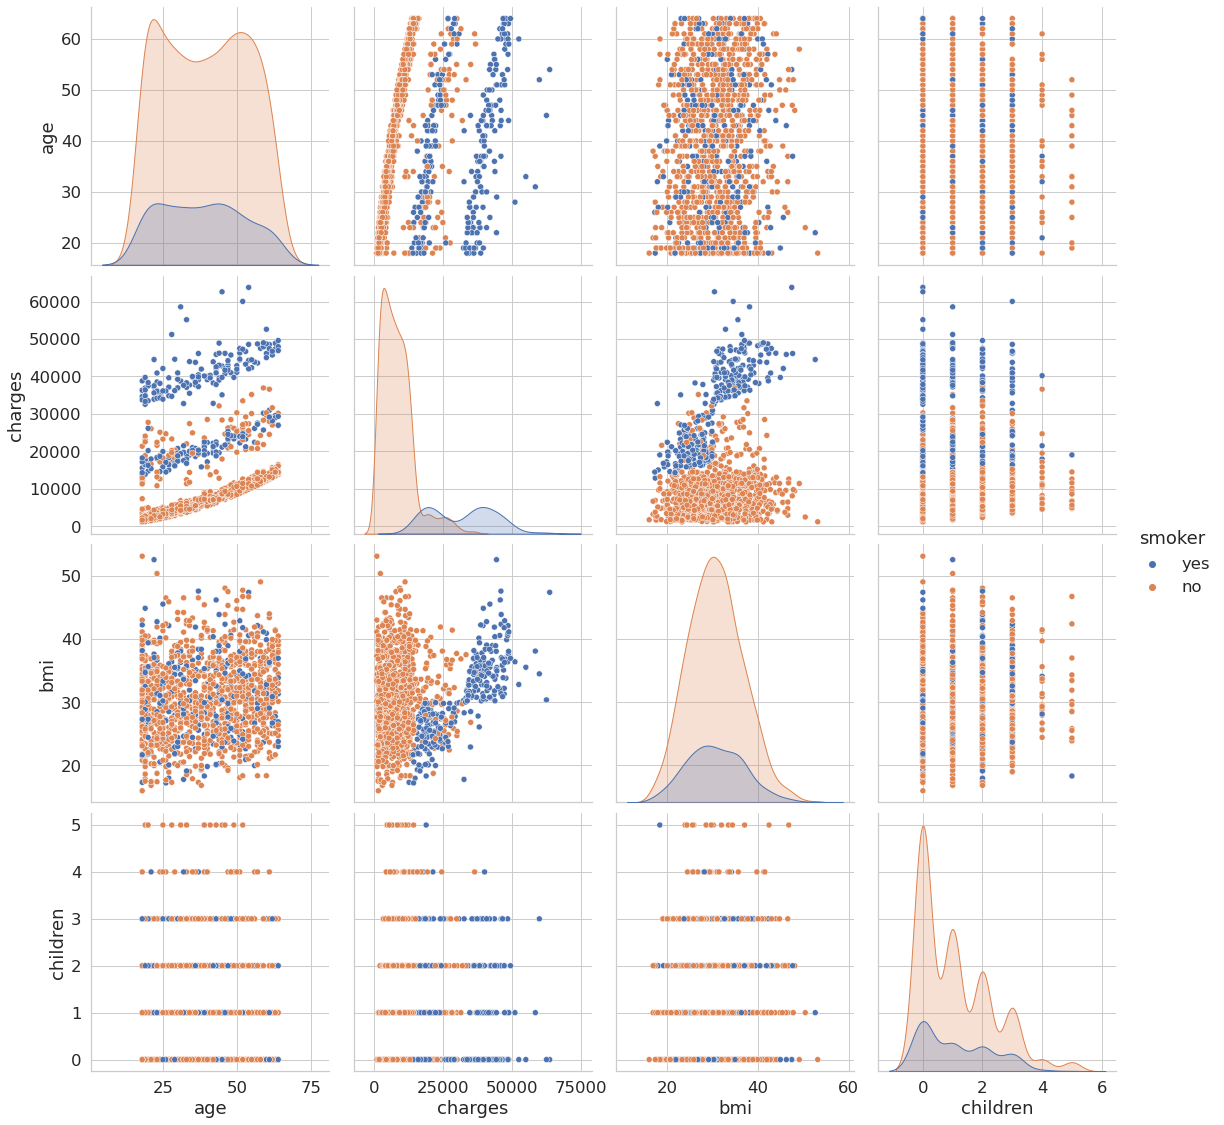

In [23]:
sns.pairplot(data=ins_data, height=4, hue='smoker', 
             x_vars=['age', 'charges', 'bmi', 'children'],
             y_vars=['age', 'charges', 'bmi', 'children'])

In [61]:
ins_data['log_charges'] = np.log(ins_data.charges)

In [25]:
ins_data.head()

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,female,27.900,0,yes,southwest,16884.92400,9.734176
1,18,male,33.770,1,no,southeast,1725.55230,7.453302
2,28,male,33.000,3,no,southeast,4449.46200,8.400538
3,33,male,22.705,0,no,northwest,21984.47061,9.998092
4,32,male,28.880,0,no,northwest,3866.85520,8.260197


# Lets dive into linear regression

Provide stratified train-test split to get balanced train and test data sets by $sex$ and $smoker$ vars.

In [62]:
ins_data['age'] = StandardScaler().fit_transform(ins_data['age'].values.reshape(-1, 1))
ins_data['bmi'] = StandardScaler().fit_transform(ins_data['bmi'].values.reshape(-1, 1))
ins_data['log_charges'] = StandardScaler().fit_transform(ins_data['log_charges'].values.reshape(-1, 1))

In [63]:
X = ins_data.drop(['charges', 'log_charges'], axis=1)
y = ins_data['log_charges']


X['age'] = StandardScaler().fit_transform(X['age'].values.reshape(-1, 1))
X['bmi'] = StandardScaler().fit_transform(X['bmi'].values.reshape(-1, 1))
y = StandardScaler().fit_transform(y.values.reshape(-1, 1))

le = LabelEncoder()

X_num = X.copy()
X_num['sex'] = le.fit_transform(X['sex'])
X_num['smoker'] = le.fit_transform(X['smoker'])
X_num['region'] = le.fit_transform(X['region'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X[['sex', 'smoker']], random_state=1)

X_train = pd.get_dummies(X_train, columns=['sex', 'smoker','region'])
X_test = pd.get_dummies(X_test, columns=['sex', 'smoker','region'])

In [65]:
ins_data_numeric = ins_data.copy()
ins_data_numeric['smoker'] = ins_data['smoker'].map({'yes': 1, 'no': 0})
ins_data_numeric['sex'] = ins_data['sex'].map({'female': 1, 'male': 0})
ins_data_numeric['region'] = ins_data['region'].map({'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3})
ins_data_numeric.head()

,age,sex,bmi,children,smoker,region,charges,log_charges
0,-1.440418,1,-0.453160,0,1,0,16884.92400,0.690636
1,-1.511647,0,0.509422,1,0,1,1725.55230,-1.793016
2,-0.799350,0,0.383155,3,0,1,4449.46200,-0.761567
3,-0.443201,0,-1.305052,0,0,2,21984.47061,0.978014
4,-0.514431,0,-0.292456,0,0,2,3866.85520,-0.914386


## Multiple Linear Regression With scikit-learn

### Building a model

In [67]:
log_charges_lm = LinearRegression()
log_charges_lm.fit(X_train, y_train)

LinearRegression()

In [68]:
print(f'R^2 = {log_charges_lm.score(X_test, y_test)}')
print(f'R^2_adj = {calc_adj_r_sq(log_charges_lm, X_test, y_test)}')

R^2 = 0.7682349394526031
R^2_adj = 0.7582762845072072


Lets try to create model without region variable.

In [69]:
X_wo_region_train = X_train.loc[:, ~X_train.columns.str.startswith('region')]
X_wo_region_test = X_test.loc[:, ~X_test.columns.str.startswith('region')]

In [70]:
log_charges_lm_2 = LinearRegression()
log_charges_lm_2.fit(X_wo_region_train, y_train)

LinearRegression()

In [71]:
print(f'R^2 = {log_charges_lm_2.score(X_wo_region_test, y_test)}')
print(f'R^2_adj = {calc_adj_r_sq(log_charges_lm_2, X_wo_region_test, y_test)}')

R^2 = 0.7678274172861406
R^2_adj = 0.7615766169823059


## Using Statmodel

Next i wiil use statmodels

In [72]:
X_train = sm.tools.add_constant(X_train)
X_test = sm.tools.add_constant(X_test)

In [73]:
full_model = sm.OLS(y_train, X_train).fit()
print(full_model.summary())

X_train_dropped = X_train.copy()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     435.9
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:24:52   Log-Likelihood:                -730.16
No. Observations:                1069   AIC:                             1478.
Df Residuals:                    1060   BIC:                             1523.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -5.143e+11   2.04e+12  

#### Remove features with $p-value$ > 0.05

In [74]:
sing_features = select_sign_covs(full_model, X_train, y_train)
trimmed_model = sm.OLS(y_train, sing_features).fit()
trimmed_model.summary()

Dropping smoker_yes and running regression again because pvalue is: 0.8010414397646457
All p values less than 0.05


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     435.9
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:24:56   Log-Likelihood:                -730.16
No. Observations:                1069   AIC:                             1478.
Df Residuals:                    1060   BIC:                             1523.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.7220      0.020     35.838      0.000       0.682       0.762
age                  0.5223      0.015     34.908      0.000       0.493       0.552
bmi                  0.0968      0.016      6.221      0.000       0.066       0.127
children             0.1033      0.012      8.461      0.000       0.079       0.127
sex_female           0.4079      0.018     22.175      0.000       0.372       0.444
sex_male             0.3141      0.017     18.073      0.000       0.280       0.348
smoker_no           -1.7251      0.037    -47.075      0.000      -1.797      -1.653
region_northeast     0.2816      0.027     10.572      0.000       0.229       0.334
region_northwest     0.2083      0.027      7.831      0.000       0.156       0.261
region_southeast     0.0845      0.026      3.249      0.001       0.033       0.136
region_southwest     0.1475      0.026      5.601      0.000       0.096       0.199
==============================================================================
Omnibus:                      345.597   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1142.656
Skew:                           1.577   Prob(JB):                    7.51e-249
Kurtosis:                       6.963   Cond. No.                     1.01e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.49e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We can see that there are now only signnificant predictors but $R^2_{adj}$ performace does not improved.

### Select only best features

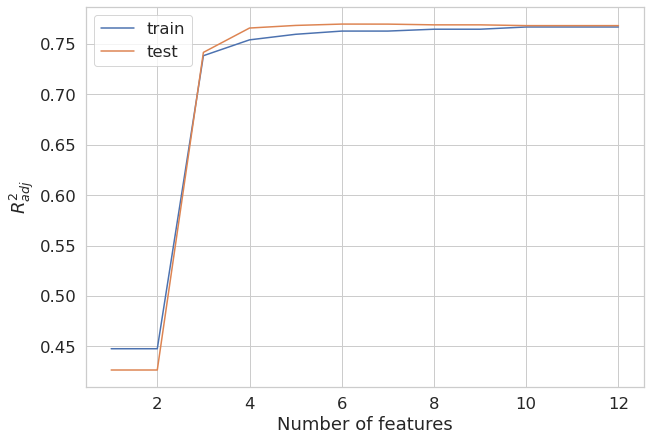

In [75]:
column_names = X_train.columns

no_of_features = []
r_squared_train = []
r_squared_test = []

max_features = X_train.shape[1]

for k in range(1, max_features + 1):
    selector = SelectKBest(f_regression, k = k)
    X_train_transformed = selector.fit_transform(X_train, y_train)
    X_test_transformed = selector.transform(X_test)
    regressor = LinearRegression()
    regressor.fit(X_train_transformed, y_train)
    no_of_features.append(k)
    r_squared_train.append(regressor.score(X_train_transformed, y_train))
    r_squared_test.append(regressor.score(X_test_transformed, y_test))
    
sns.lineplot(x = no_of_features, y = r_squared_train, label='train', legend='full')
sns.lineplot(x = no_of_features, y = r_squared_test, label='test', legend='full')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('$R^2_{adj}$')
plt.show()

In [76]:
best_no_features = r_squared_test.index(max(r_squared_test)) + 1
best_no_features

6

In [77]:
# Best score k = 7
selector = SelectKBest(f_regression, k = 6)
X_train_transformed = selector.fit_transform(X_train, y_train)
X_test_transformed = selector.transform(X_test)
column_names[selector.get_support()]

Index(['age', 'bmi', 'children', 'smoker_no', 'smoker_yes',
       'region_northeast'],
      dtype='object')

In [78]:
rf_r_sq = RandomForestRegressor().fit(X_train_transformed, y_train).score(X_test_transformed, y_test) 

In [79]:
result_model_sm = sm.OLS(y_train, X_train_transformed).fit()
sm_lm_r_sq = result_model_sm.rsquared_adj

In [80]:
n, p = X_train_transformed.shape

In [92]:
result_model_skl = LinearRegression().fit(X_train_transformed, y_train)
y_pred = result_model_skl.predict(X_test_transformed)
r2_skl = metrics.r2_score(y_test, y_pred)
r2_adj = 1 - (1 - r2_skl) * (n - 1) / (n - p - 1)
r2_adj

0.7684669190091001

In [93]:
result = pd.DataFrame({'Model': ['Random_Forest', 'Linear model'], '$R^2_{adj}$': [rf_r_sq, r2_adj]})
result

,Model,$R^2_{adj}$
0,Random_Forest,0.771299
1,Linear model,0.768467


In [83]:
X_tr, X_te, y_tr, y_te = train_test_split(X_num, y, test_size=0.2, stratify=X[['sex', 'smoker']], random_state=1)

In [84]:
inter_data_train = X_tr.copy()
inter_data_test = X_te.copy()
inter_data_train['log_charges'] = y_tr
#inter_data_test['log_charges'] = y_te

In [85]:
inter_model = smf.ols('log_charges ~ (age + bmi + C(sex) + children + C(smoker) + region) ** 2', data=inter_data_train).fit()
inter_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_charges   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     268.3
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:25:38   Log-Likelihood:                -517.90
No. Observations:                1069   AIC:                             1080.
Df Residuals:                    1047   BIC:                             1189.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.3508      0.039     -9.090      0.000      -0.427      -0.275
C(sex)[T.1]                   -0.0843      0.049     -1.715      0.087      -0.181       0.012
C(smoker)[T.1]                 1.6402      0.066     24.735      0.000       1.510       1.770
C(sex)[T.1]:C(smoker)[T.1]     0.1322      0.062      2.132      0.033       0.011       0.254
age                            0.5734      0.027     21.596      0.000       0.521       0.625
age:C(sex)[T.1]                0.0741      0.025      2.977      0.003       0.025       0.123
age:C(smoker)[T.1]            -0.5146      0.031    -16.798      0.000      -0.575      -0.455
bmi                            0.0403      0.028      1.438      0.151      -0.015       0.095
bmi:C(sex)[T.1]                0.0062      0.025      0.244      0.807      -0.043       0.056
bmi:C(smoker)[T.1]             0.3279      0.031     10.646      0.000       0.267       0.388
children                       0.1558      0.021      7.344      0.000       0.114       0.197
C(sex)[T.1]:children          -0.0121      0.020     -0.596      0.551      -0.052       0.028
children:C(smoker)[T.1]       -0.1356      0.027     -5.116      0.000      -0.188      -0.084
region                        -0.0565      0.019     -2.907      0.004      -0.095      -0.018
C(sex)[T.1]:region            -0.0139      0.023     -0.617      0.538      -0.058       0.030
C(smoker)[T.1]:region          0.0763      0.028      2.680      0.007       0.020       0.132
age:bmi                       -0.0148      0.013     -1.168      0.243      -0.040       0.010
age:children                  -0.0612      0.011     -5.523      0.000      -0.083      -0.039
age:region                     0.0531      0.012      4.587      0.000       0.030       0.076
bmi:children                   0.0021      0.010      0.200      0.842      -0.018       0.023
bmi:region                    -0.0272      0.012     -2.261      0.024      -0.051      -0.004
children:region               -0.0092      0.009     -1.002      0.316      -0.027       0.009
==============================================================================
Omnibus:                      762.878   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8961.388
Skew:                           3.295   Prob(JB):                         0.00
Kurtosis:                      15.560   Cond. No.                         26.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
fitted = inter_model.predict(inter_data_test)
metrics.r2_score(y_te, fitted)

0.8174352563564573

In [ ]:
ins_data_numeric

So the best $R^2_{adj}$ is 0.82 with full model with interactions, but mb it is harder to interprete it.

### Try to apply propensity score

In [87]:
log_regr_model = LogisticRegression().fit(ins_data_numeric[['age', 'sex', 'bmi', 'children', 'region']], ins_data_numeric['smoker'])

In [88]:
prop_score = log_regr_model.predict_proba(ins_data_numeric[['age', 'sex', 'bmi', 'children', 'region']])

In [89]:
weights = ins_data_numeric['smoker'] * 1 / prop_score[:, 1] + 1 / (1 - prop_score[:, 1]) * ins_data_numeric['smoker']

In [90]:
smf.wls('log_charges ~ (age + bmi + C(sex) + children + C(smoker) + region) ** 2', data=ins_data_numeric, weights=weights).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:            log_charges   R-squared:                       0.768
Model:                            WLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     291.8
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:26:02   Log-Likelihood:                   -inf
No. Observations:                1337   AIC:                               inf
Df Residuals:                    1321   BIC:                               inf
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.6569      0.009     75.328      0.000       0.640       0.674
C(sex)[T.1]                   -0.0100      0.011     -0.885      0.376      -0.032       0.012
C(smoker)[T.1]                 0.6569      0.009     75.328      0.000       0.640       0.674
C(sex)[T.1]:C(smoker)[T.1]    -0.0100      0.011     -0.885      0.376      -0.032       0.012
age                            0.0845      0.006     13.063      0.000       0.072       0.097
age:C(sex)[T.1]               -0.0374      0.012     -3.210      0.001      -0.060      -0.015
age:C(smoker)[T.1]             0.0845      0.006     13.063      0.000       0.072       0.097
bmi                            0.1587      0.006     25.503      0.000       0.147       0.171
bmi:C(sex)[T.1]               -0.0067      0.011     -0.591      0.555      -0.029       0.016
bmi:C(smoker)[T.1]             0.1587      0.006     25.503      0.000       0.147       0.171
children                      -0.0041      0.005     -0.869      0.385      -0.013       0.005
C(sex)[T.1]:children           0.0208      0.010      2.058      0.040       0.001       0.041
children:C(smoker)[T.1]       -0.0041      0.005     -0.869      0.385      -0.013       0.005
region                         0.0023      0.004      0.522      0.602      -0.006       0.011
C(sex)[T.1]:region             0.0013      0.011      0.118      0.906      -0.020       0.023
C(smoker)[T.1]:region          0.0023      0.004      0.522      0.602      -0.006       0.011
age:bmi                       -0.0249      0.006     -4.084      0.000      -0.037      -0.013
age:children                  -0.0015      0.005     -0.285      0.776      -0.012       0.009
age:region                    -0.0089      0.006     -1.570      0.117      -0.020       0.002
bmi:children                  -0.0121      0.005     -2.500      0.013      -0.022      -0.003
bmi:region                     0.0158      0.006      2.848      0.004       0.005       0.027
children:region                0.0049      0.005      1.052      0.293      -0.004       0.014
==============================================================================
Omnibus:                      563.002   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14152.078
Skew:                           1.385   Prob(JB):                         0.00
Kurtosis:                      18.696   Cond. No.                     1.11e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.63e-30. This might indicate that there are
strong multicollinearity problems or that the design matri

So unfortunatelly it does not work at all, mb because $smoker$ does not depend on other variables in data.

### Cheking conditions of applicability

#### Cook's distances

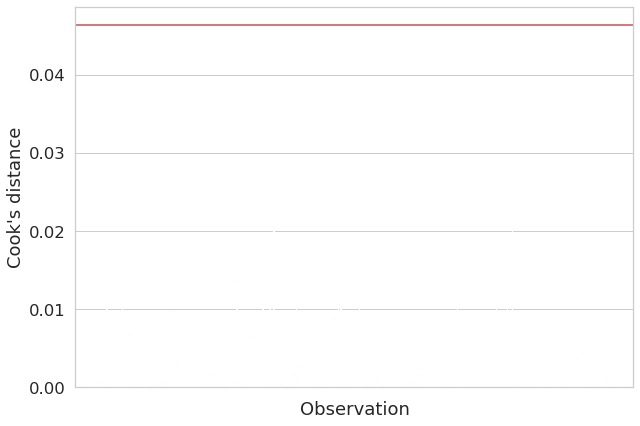

In [96]:
cooks_distances_stat_models(result_model_sm, y_test)

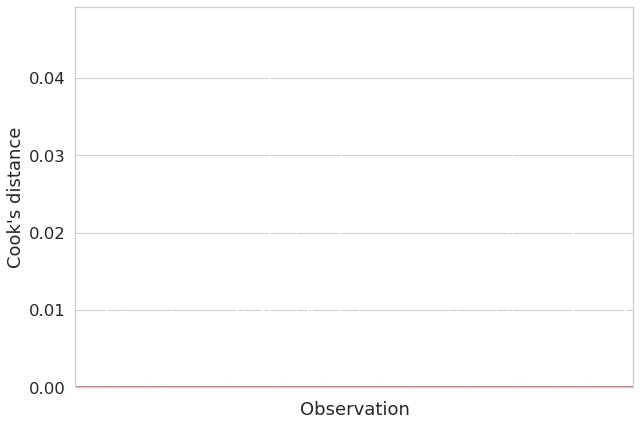

In [94]:
cooks_distances_stat_models(inter_model, ins_data_numeric['log_charges'])

#### Model residues

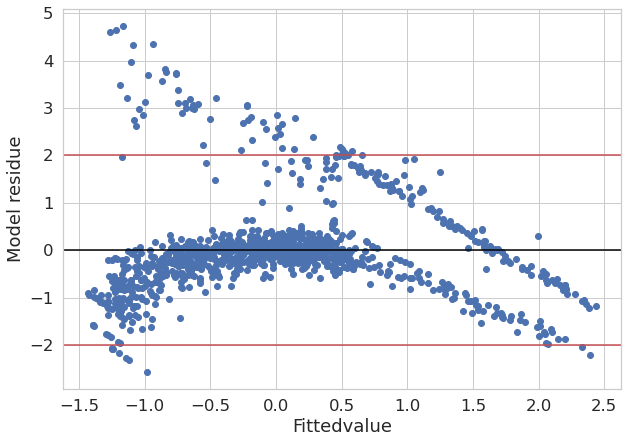

In [98]:
resid_distribution(result_model_sm)

In [ ]:
#inter_model = smf.ols('log_charges ~ (age + bmi + sex + children + smoker + region) ** 2 - sex:children - children:region - sex:region', data=ins_data_numeric).fit()
#inter_model.summary()

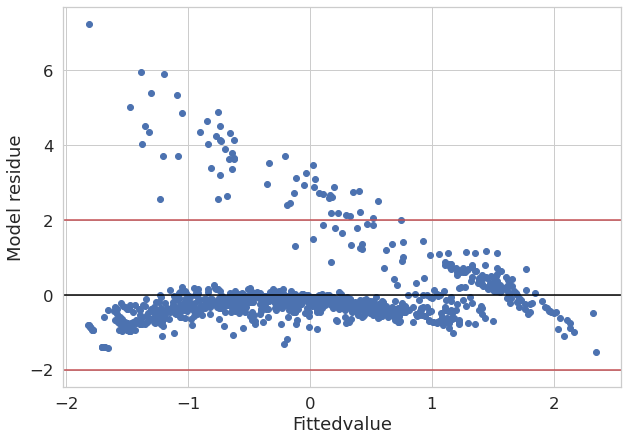

In [99]:
resid_distribution(inter_model)

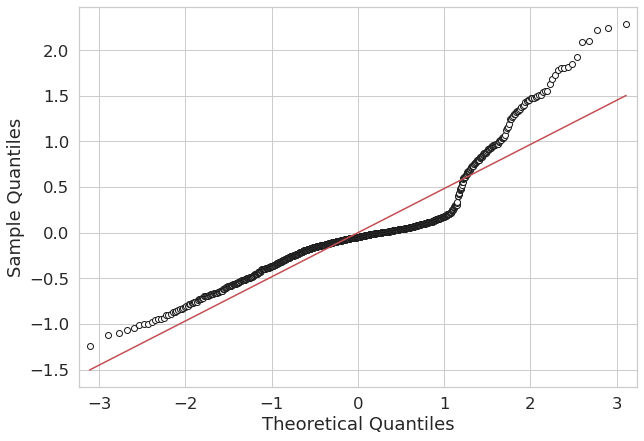

In [100]:
qqPlot(result_model_sm.resid)

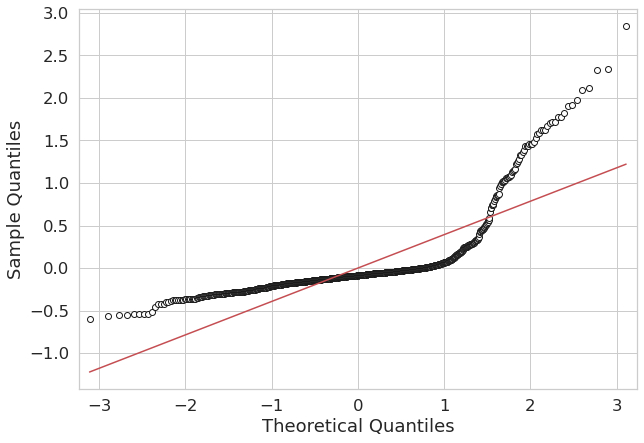

In [101]:
qqPlot(inter_model.resid)

Seems like situation is not pretty perfect for application of linear models. Especially in residues distriburion but there are a lot of observations so estimation of $t-statistics$ might be robust.

## Lets try to find some silent variable

Here we can see that in our data some silent dependences took its place.
I think it may be a good idea to cluster data and label observations with new variable. 
Then make a new model and check if it will be better. Unfortunatelly we cant apply rhis strategy to predict charges, but
we can clearify that model may be better if we put additional covariate in data set.

Here i tried some clustering algorithms, but KMeans and Agglomerative clustering perfrormed best results (and also pretty similar ones) so i decided to use only KMeans

Check if dummies affects KMeans

In [102]:
kmeans_1 = KMeans(n_clusters=3, random_state=1).fit(pd.get_dummies(ins_data, columns=['sex', 'smoker','region']))

In [103]:
kmeans = KMeans(n_clusters=3, random_state=1).fit(ins_data_numeric)

In [104]:
sum(kmeans_1.labels_ == kmeans.labels_) == len(kmeans.labels_)

True

So it does not affets

Lets see how many clusters do we need to take for KMeans

Text(0, 0.5, '$J(C_k)$')

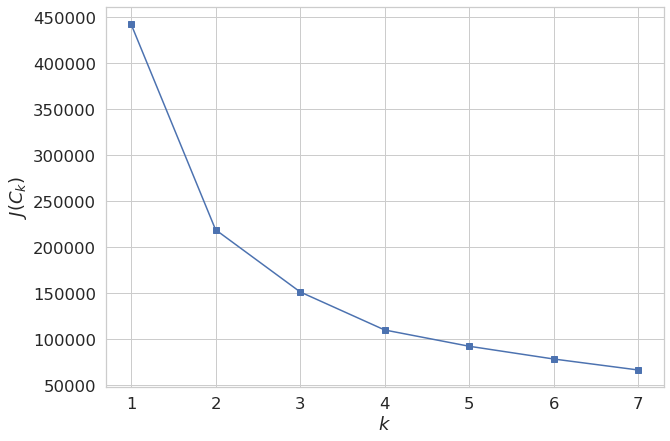

In [105]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(ins_data_numeric)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 8), inertia, marker='s')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

It can seems to be 2, 3 or even 4. Lets see on silhouette score.

Text(0, 0.5, '$Silhouette$')

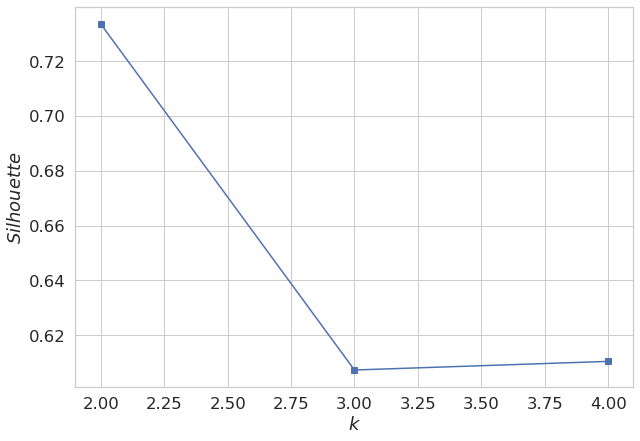

In [106]:
silhouette = []
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(ins_data_numeric)
    silh = metrics.silhouette_score(ins_data_numeric, kmeans.labels_)
    silhouette.append(silh)

plt.plot(range(2, 5), silhouette, marker='s')
plt.xlabel('$k$')
plt.ylabel('$Silhouette$')

As we can see 3 clusters for KMeans is the best way, but we ckeck 2 and 4 too. Lets label our data, run PCA and see how our labels could color PCA plot.

In [107]:
kmeans_2 = KMeans(n_clusters=2, random_state=1).fit(ins_data_numeric)
kmeans_3 = KMeans(n_clusters=3, random_state=1).fit(ins_data_numeric)
kmeans_4 = KMeans(n_clusters=4, random_state=1).fit(ins_data_numeric)
ins_data_numeric['label'] = kmeans_3.labels_

Projecting 9-dimensional data to 2D


Text(0.5, 1.0, 'MNIST. PCA projection')

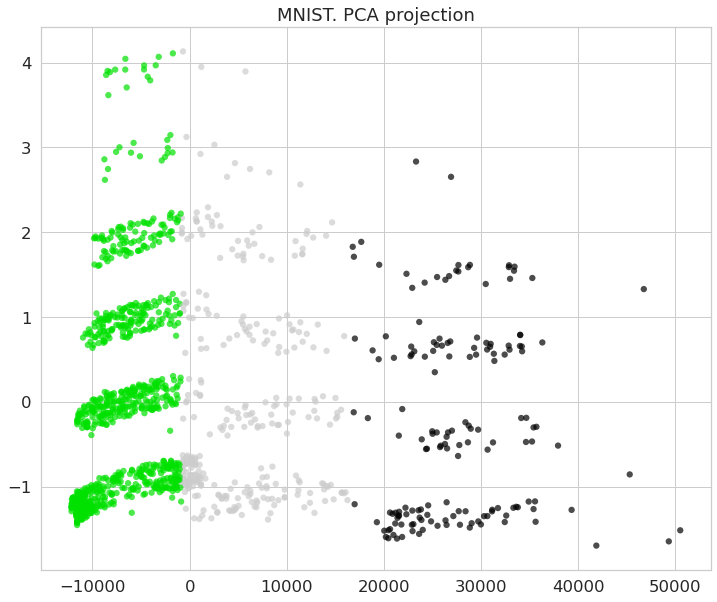

In [108]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(ins_data_numeric)

print('Projecting %d-dimensional data to 2D' % ins_data_numeric.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_3.labels_, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.title('MNIST. PCA projection')

Does not look perfect but it is nice. Lets see on $R^2_{adj}$

In [109]:
ins_data_numeric['label'] = kmeans_2.labels_
X_t = ins_data_numeric.drop(['charges', 'log_charges'], axis=1)
y_t = ins_data_numeric['log_charges']
mod = LinearRegression().fit(X_t, y_t)
mod.score(X_t, y_t)

0.8094411402283315

In [110]:
ins_data_numeric['label'] = kmeans_3.labels_
X_t = ins_data_numeric.drop(['charges', 'log_charges'], axis=1)
y_t = ins_data_numeric['log_charges']
mod = LinearRegression().fit(X_t, y_t)
mod.score(X_t, y_t)

0.7668619239075769

In [111]:
ins_data_numeric['label'] = kmeans_4.labels_
X_t = ins_data_numeric.drop(['charges', 'log_charges'], axis=1)
y_t = ins_data_numeric['log_charges']
mod = LinearRegression().fit(X_t, y_t)
mod.score(X_t, y_t)

0.8113172861864089

$R^2_{adj}$ tells us that 2 clusters is the best. So 2 or 3 clusters may be a reall features of our data, I think this variable may reflect the life lelvel (low, middle or high)